In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
from pyDOE import lhs
import torch.optim as optim

In [ ]:
# !git clone https://github.com/broccubali/NoisyICML.git

Cloning into 'NoisyICML'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 320 (delta 49), reused 64 (delta 16), pack-reused 202 (from 1)
Receiving objects: 100% (320/320), 88.75 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [31]:
# again.
import torch.nn.init as init
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList(
            [
                nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                if i % 2 == 0
                else nn.SiLU()
                for i in range(10)
            ]
        )
        self.layers.append(nn.Linear(hidden_size, output_size))
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.xavier_normal_(layer.weight)  # Initialize weights
                if layer.bias is not None:  # Initialize biases to zero
                    init.zeros_(layer.bias)

        # Trainable parameter for the wave number squared (k^2)
        self.a1 = nn.Parameter(torch.tensor([0.7], dtype=torch.float32, device="cuda"))
        self.a2 = nn.Parameter(torch.tensor([0.7], dtype=torch.float32, device="cuda"))
        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.loss = nn.MSELoss()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def loss_fn(self, train, u):
        u_pred = self.forward(train)
        return self.loss(u_pred, u)

    def residual_loss(self, train):
        # Physics-informed loss based on the Helmholtz equation
        g = train.clone()
        g.requires_grad = True
        u_pred = self.forward(g)

        # Compute the gradients for second derivatives (u_xx and u_tt)
        u_diff = torch.autograd.grad(
            u_pred, g, torch.ones_like(u_pred), create_graph=True, retain_graph=True
        )[0]
        u_x = u_diff[:, 0]
        u_y = u_diff[:, 1]
        u_xx = torch.autograd.grad(
            u_x, g, torch.ones_like(g[:, 0]), create_graph=True
        )[0][:, 0] # <---- Similar modification to select the second derivative with respect to X
        u_yy = torch.autograd.grad(
            u_y, g, torch.ones_like(g[:, 1]), create_graph=True
        )[0][:, 1]
        k2 = (self.a1**2 + self.a2**2) * np.pi**2
        fhat = -k2 * torch.sin(self.a1 * np.pi * g[:, 0]) * torch.sin(self.a2 * np.pi * g[:, 1])
        residual = u_xx + u_yy + ((k2) * u_pred) - fhat # <---- Also fixed k to k2
        return self.loss(residual, torch.zeros_like(residual))

    def total_loss(self, train, utrain,):
        alpha_female = 10.0
        data_loss = self.loss_fn(train, utrain)  # Match observed data
        physics_loss = self.residual_loss(train)  # Enforce governing equations
        return data_loss, physics_loss, data_loss + physics_loss


    def train_model(self, train, utrain, epochs=100):
        self.train()
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            a, b, loss = self.total_loss(train, utrain)
            loss.backward()
            self.optimizer.step()
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item()}, a1 = {self.a1.item()}, a2 = {self.a2.item()}, Data Loss = {a.item()}, Physics Loss = {b.item()}")

In [39]:
x = np.linspace(-1, 1, 101)
y = np.linspace(-1, 1, 101)
X, Y = np.meshgrid(x, y)

# True wave numbers
a1_true, a2_true = 1.0, 1.0
u_true = np.sin(a1_true * np.pi * X) * np.sin(a2_true * np.pi * Y)  # True solution
u_true.shape

(101, 101)

In [54]:
device = "cuda"
X_train = torch.tensor(X.flatten(), dtype=torch.float32).to(device)
Y_train = torch.tensor(Y.flatten(), dtype=torch.float32).to(device)
U_train = torch.tensor(u_true.T.flatten(), dtype=torch.float32).to(device)
train = torch.stack((X_train, Y_train), dim=1).to(device)
train.shape

torch.Size([10201, 2])

In [55]:
# idx = np.random.choice(train.shape[0], 10000, replace=False)
# train = train[idx, :]
# U_train = U_train[idx, None]
# train.shape, U_train.shape

In [56]:
model = PINN(input_size=2, hidden_size=50, output_size=1).to(device)
model.train_model(train, U_train, epochs=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]/home/shusrith/projects/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10201])) that is different to the input size (torch.Size([10201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 3/2000 [00:00<01:30, 22.19it/s]

Epoch 1/2000, Loss = 0.2451324462890625, a1 = 0.005596859380602837, a2 = 0.2331409603357315, Data Loss = 0.24507784843444824, Physics Loss = 5.459379099193029e-05


  5%|▌         | 104/2000 [00:06<01:57, 16.16it/s]

Epoch 101/2000, Loss = 0.24507403373718262, a1 = 0.00027282972587272525, a2 = 0.15129773318767548, Data Loss = 0.24507401883602142, Physics Loss = 8.548785679352022e-09


 10%|█         | 204/2000 [00:12<01:51, 16.15it/s]

Epoch 201/2000, Loss = 0.24507401883602142, a1 = 0.00014651946548838168, a2 = 0.15128807723522186, Data Loss = 0.24507401883602142, Physics Loss = 4.0242471577300876e-09


 15%|█▌        | 304/2000 [00:18<01:44, 16.16it/s]

Epoch 301/2000, Loss = 0.24507401883602142, a1 = 0.00015262117085512727, a2 = 0.15128807723522186, Data Loss = 0.24507401883602142, Physics Loss = 2.1907555769473674e-09


 20%|██        | 404/2000 [00:25<01:38, 16.16it/s]

Epoch 401/2000, Loss = 0.24507401883602142, a1 = 0.00015603392967022955, a2 = 0.15128807723522186, Data Loss = 0.24507401883602142, Physics Loss = 1.0858990373563415e-09


 25%|██▌       | 504/2000 [00:31<01:32, 16.16it/s]

Epoch 501/2000, Loss = 0.24507401883602142, a1 = 0.00015776885265950114, a2 = 0.15128807723522186, Data Loss = 0.24507401883602142, Physics Loss = 5.042314898950906e-10


 30%|███       | 604/2000 [00:37<01:26, 16.16it/s]

Epoch 601/2000, Loss = 0.24507401883602142, a1 = 0.00015865360910538584, a2 = 0.15128807723522186, Data Loss = 0.24507401883602142, Physics Loss = 2.338781945887547e-10


 35%|███▍      | 697/2000 [00:43<01:21, 16.03it/s]


KeyboardInterrupt: 

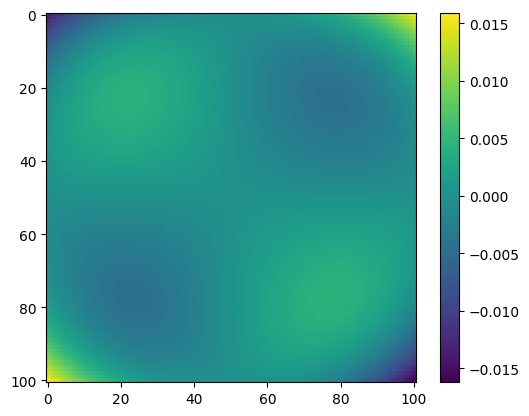

In [48]:
import matplotlib.pyplot as plt

with torch.no_grad():
    u_pred = model(train).cpu().numpy()
plt.imshow(u_pred.reshape(101, 101), cmap="viridis")
plt.colorbar()
plt.show()

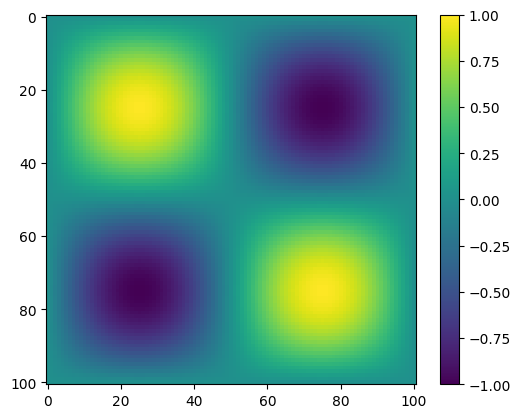

In [45]:
plt.imshow(u_true, cmap="viridis")
plt.colorbar()
plt.show()

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm

def visualize_helmholtz(X, Y, data, path):
    """
    Visualizes the 2D Helmholtz solution as an animation.

    Args:
    X, Y : Meshgrid coordinates for plotting
    data : 3D NumPy array [time, X, Y] representing the solution at different times
    path : Path to save the animation
    """
    fig, ax = plt.subplots()

    # Use contour plot or imshow
    im = ax.imshow(data[0], extent=[X.min(), X.max(), Y.min(), Y.max()],
                   origin='lower', cmap='viridis', animated=True)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title("Helmholtz Equation Solution Animation")

    def update(frame):
        im.set_array(data[frame])  # Update solution at new time step
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(data), interval=50, blit=False)

    writer = animation.PillowWriter(fps=15, bitrate=1800)
    ani.save(path, writer=writer)
    plt.close(fig)

# Example Usage
# Generate example Helmholtz solution data
# x = np.linspace(-1, 1, 100)
# y = np.linspace(-1, 1, 100)
# X, Y = np.meshgrid(x, y)

# # Example 2D Helmholtz wave solution evolving over time
# time_steps = 50
# a1, a2 = 1, 1
# data = np.array([np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y) * np.cos(2 * np.pi * t / time_steps)
#                  for t in range(time_steps)])

# Visualize and save
# visualize_helmholtz(X, Y, data, "helmholtz_solution.gif")

In [13]:
x, y = X_train[:1024], Y_train[:1024]
X, Y = np.meshgrid(x.cpu().numpy(), y.cpu().numpy())
a = torch.stack((x, y), dim=1).to(device)
u = model(a).detach().cpu().nump


y().reshape(32, 32)
u.shape, X.shape, Y.shape

((32, 32), (1024, 1024), (1024, 1024))

In [50]:
# Create 50 time steps by adding small variations (e.g., sine wave modulation)
t = np.linspace(0, 2 * np.pi, 50)
u_time_series = np.array([u_true * np.sin(ti) for ti in t])
# u_time_series = u_time_series[:, :, :]
u_time_series.shape

(50, 101, 101)

In [51]:
visualize_helmholtz(X, Y, u_time_series, "helmholtz_solution.gif")